In [1]:
from IPython.display import Image

# 7.3 배깅 : 부트스트랩 샘플링을 통한 분류 앙상블
* 원본 훈련 데이터셋에서 부트스트랩 샘플(중복을 허용한 랜덤 샘플)을 뽑아 사용.
* 배깅을 bootstrap aggregating이라고도 한다.


In [2]:
# 배깅
Image(url='https://git.io/Jtsk4', width=500) 

### 7.3.1 배깅 알고리즘의 작동 방식

* 배깅 단계에서 중복을 허용하여 랜덤하게 샘플링
    * 랜덤 샘플 = 배깅 1, 배깅 2 등
    * 각 부분 집합에는 일부가 중복되어 있고 원본 샘플 중 일부는 포함되어 있지 않다.
* 각각의 부트스트랩 샘플을 사용하여 분류기 $C_{j}$를 학습
* 일반적으로 가지치기하지 않은 결정 트리를 분류기로 사용
* 개별 분류기가 부트스트랩 샘플에 학습되고 나면 다수결 투표를 사용하여 예측을 모은다.
* 랜덤 포레스트 = 개별 결정 트리를 학습할 때 랜덤하게 특성의 부분 집합을 선택하는 배깅의 특별한 경우이다.

In [3]:
Image(url='https://git.io/JtskB', width=400) 

### 7.3.2 배깅으로 Wine 데이터셋의 샘플 분류

In [4]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# 클래스 2와 클래스 3만 사용하여 두개의 특성 Alcohol과 0D280/0D315 of diluted wines만 사용
# 클래스 1 제외
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

* 사이킷런에는 BaggingClassifier 클래스 분류기
    * 훈련 데이터셋으로부터 추출한 부트스트랩 샘플에서 가지치기가 없는 500개의 결정 트리를 학습하여 앙상블을 만든다.

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [7]:
# 배깅 분류기와 가지치기가 없는 단일 결정 트리에서 훈련 데이터셋과 테스트 데이터셋의 예측 정확도를 계산하여 성능 비교
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f' % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' % (bag_train, bag_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833
배깅의 훈련 정확도/테스트 정확도 1.000/0.917


결정 트리와 배깅 분류기의 훈련 정확도가 훈련 데이터셋에서 둘 다 100%이지만 테스트 데이터셋의 정확도로 보아 배깅 분류기가 일반화 성능이 더 나은 것 같다.

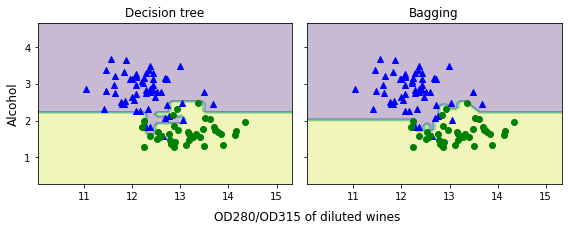

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 결정 트리와 배깅 분류기의 결정 경계를 비교
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

fig, ax = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax[idx].contourf(xx, yy, Z, alpha=0.3)
    ax[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    ax[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    ax[idx].set_title(tt)

ax[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=ax[1].transAxes)

plt.show()

고차원 데이터셋을 사용하는 더 복잡한 분류 문제라면 단일 결정 트리가 쉽게 과대적합 될 수 있다. 이런 경우 배깅 알고리즘의 강력함이 제대로 발휘될 수 있다. 마지막으로 배깅 알고리즘은 모델의 분산을 감소하는 효과적인 방법이지만 모델의 편향을 낮추는 데는 효과적이지 않다.

즉, 모델이 너무 단순해서 데이터에 있는 경향을 잘 잡아내지 못한다. 이것이 배깅을 수행할 때 편향이 낮은 모델, 가지치기하지 않은 결정 트리를 분류기로 사용하여 앙상블을 만드는 이유이다.

* OOB(Out Of Bag) 샘플
    * 랜덤 포레스트와 배깅은 모두 기본적으로 부트스트랩 샘플링을 사용하기 때문에 분류기마다 훈련에 사용하지 않는 여분의 샘플.
    * 이 샘플을 사용하면 검증 데이터셋을 만들지 않고 앙상블 모델을 평가할 수 있다.
    * oob_score=True, default=False.

* 사이킷런의 랜덤 포레스트
    * 분류일 경우 OOB 샘플에 각 트리의 예측 확률을 누적하여 가장 큰 확률을 가진 클래스를 타깃과 비교하여 정확도를 계산.
    * 회귀일 경우 각 트리의 예측 평균에 대한 R^2 점수를 계산한다.
        * 이 점수는 oob_score_ 속성에 저장되어 있다.

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(oob_score=True, random_state=1)
rf.fit(X_train, y_train)

rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)

print('랜덤 포레스트의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (rf_train_score, rf_test_score))
print('랜덤 포레스트의 OOB 정확도 %.3f' % rf.oob_score_)

랜덤 포레스트의 훈련 정확도/테스트 정확도 1.000/0.917
랜덤 포레스트의 OOB 정확도 0.884


배깅의 OOB 점수 계산 방식은 랜덤 포레스트와 거의 동일하다. 다만 `base_estimator`에 지정된 분류기가 `predict_proba` 메서드를 지원하지 않을 경우 예측 클래스를 카운팅하여 가장 높은 값의 클래스를 사용해 정확도를 계산.

In [10]:
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, oob_score=True, random_state=1)
bag.fit(X_train, y_train)

bag_train_score = bag.score(X_train, y_train)
bag_test_score = bag.score(X_test, y_test)

print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (bag_train_score, bag_test_score))
print('배깅의 OOB 정확도 %.3f' % bag.oob_score_)

배깅의 훈련 정확도/테스트 정확도 1.000/0.917
배깅의 OOB 정확도 0.895


# 7.4 약한 학습기를 이용한 에이다부스트
* 부스팅(boosting)
    * ex) 에이다부스트(AdaBoost, Adaptive Boosting)
* 부스팅에서 앙상블은 약한 학습기라고도 하는 매우 간단한 분류기로 구성된다.
    * 랜덤 추측보다 조금 성능이 좋을 뿐이다.
    * ex) 깊이가 1인 결정 트리.
    * 잘못 분류된 훈련 샘플을 그다음 약한 학습기가 학습하여 앙상블 성능을 향상.

### 7.4.1 부스팅 작동 원리

배깅과는 달리 부스팅의 초창기 방법은 중복을 허용하지 않고 훈련 데이터셋에서 랜덤 샘플을 추출하여 부분 집합을 구성한다.

* 원본 부스팅 과정
    1. 훈련 데이터셋 D에서 중복을 허용하지 않고 랜덤한 부분 집합 d1을 뽑아 약한 학습기 C1을 훈련.
    2. 훈련 데이터셋에서 중복을 허용하지 않고 두 번째 랜덤한 훈련 부분 집합 d2를 뽑고 이전에 잘못 분류된 샘플의 50%를 더해서 약한 학습기 C2를 훈련
    3. 훈련 데이터셋 D에서 C1과 C2에서 잘못 분류한 훈련 샘플 d3를 찾아 세 번째 약한 학습기인 C3를 훈련
    4. 약한 학습기 C1, C2, C3를 다수결 투표로 연결

부스팅은 배깅 모델에 비해 분산과 편향을 감소시킬 수 있다. 실제로는 에이다부스트 같은 부스팅 알고리즘이 분산이 높다고 알려져 있다. -> 훈련 데이터에 과대적합되는 경향이 있다.

* 에이다부스트
    * 약한 학습기를 훈련할 때 훈련 데이터셋 전체를 사용한다.
    * 훈련 샘플은 반복마다 가중치가 다시 부여되며 이 앙상블은 이전 학습기의 실수를 학습하는 강력한 분류기를 만든다.

In [11]:
# 에이다부스트
Image(url='https://git.io/Jtsk0', width=400) 

* 그림(1) : 이진 분류를 위한 훈련 데이터셋
    * 모든 샘플은 동일한 가중치를 가진다.
    * 이 훈련 데이터셋을 바탕으로 깊이가 1인 결정 트리(파선)를 훈련하여 샘플을 두 개의 클래스(삼각형과 원)로 나눈다.
    * 가능한 비용함수(또는 결정 트리 앙상블일 경우 불순도 점수)를 최소화하는 트리 훈련

* 그림(2) : 이전에 잘못 분류된 샘플 두 개(원)에 큰 가중치를 부여.
    * 올바르게 분류된 샘플의 가중치는 낮춘다.
    * 다음 결정 트리는 가장 큰 가중치를 가진 훈련 샘플에 더 집중할 것이다.
    * 세 개의 원 모양 샘플을 잘못 분류한다.

* 그림(3) : 잘못 분류된 원 모양 샘플에 큰 가중치 부여
* 그림(4) : 서로 다른 가중치가 부여된 훈련 데이터셋에서 훈련된 세 개의 약한 학습기를 다수결 투표 방식으로 합친다.

In [12]:
# 열 개의 훈련 샘플로 구성된 훈련 데이터셋
Image(url='https://git.io/Jtskg', width=500)

### 7.4.2 사이킷런 에이다부스트

In [13]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

In [14]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f' % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f' % (ada_train, ada_test))

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875
에이다부스트의 훈련 정확도/테스트 정확도 1.000/0.917


* 깊이가 1인 결정 트리는 훈련 데이터에 과소적합.
* 에이다부스트 모델은 훌녀 데이터셋의 모든 클래스 레이블을 정확하게 예측하고 기이가 1인 결정 트리에 비해 테스트 데이터셋 성능도 좀 더 높다. 훈련 성능과 테스트 성능 사이에 간격이 크므로 모델의 편향을 줄여 추가적인 분산이 발생

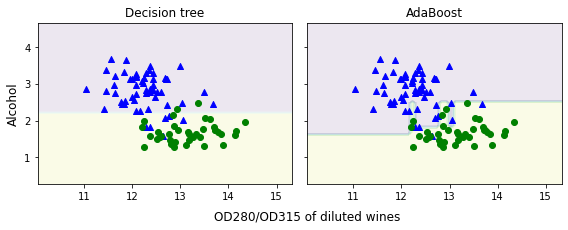

In [15]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax[idx].contourf(xx, yy, Z, alpha=0.1)
    ax[idx].scatter(X_train[y_train == 0, 0],
                    X_train[y_train == 0, 1],
                    c='blue', marker='^')
    ax[idx].scatter(X_train[y_train == 1, 0],
                    X_train[y_train == 1, 1],
                    c='green', marker='o')
    ax[idx].set_title(tt)

ax[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=ax[1].transAxes)

plt.show()

* 앙상블 학습은 개별 분류기에 비해 계산 복잡도가 높다는 단점을 가지고 있다.

#### 그레이디언트 부스팅
* 이전의 약한 학습기가 만든 **잔차 오차**(residual error)에 대해 학습하는 새로운 학습기를 추가한다.
* 신경망 알고리즘이 잘 맞는 이미지, 텍스트 같은 데이터를 제외하고 구조적인 데이터셋에서 현재 가장 높은 성능을 알고리즘 중 하나이다.
* `GradientBoostingClassifier`, `GradientBoostingRegressor` 

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)
gbrt.fit(X_train, y_train)

gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)

print('그래디언트 부스팅의 훈련 정확도/테스트 정확도 %.3f/%.3f' 
      % (gbrt_train_score, gbrt_test_score))

그래디언트 부스팅의 훈련 정확도/테스트 정확도 1.000/0.917


20개의 트리를 사용하여 에이디부스트 모델과 동일한 성능을 냈다.

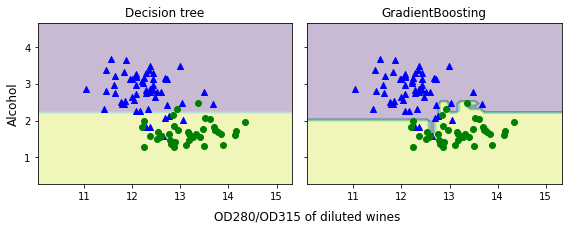

In [17]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, gbrt],
                        ['Decision tree', 'GradientBoosting']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

* 그레이디언트 부스팅의 매개변수
    * learning_rate : 각 트리가 오차에 기여하는 정도를 조절. 작으면 성능은 높아지지만 많은 트리가 필요. default=0.1
    * loss : 손실 함수
        * GradientBoostingClassifier : 로지스틱 회귀를 의미하는 'deviance'가 기본값.
        * GradientBoostingRegressor : 최소 제곱을 의미하는 'sqaured_error'가 기본값
    * criterion : 불순도 조건
        * DecisionTreeRegressor의 불순도 조건을 따라서 `'squared_error'`, `'mae'`, `'friedman_mse'`(기본값) 등을 사용
    * subsample : 기본값 1.0보다 작은 값으로 지정 시 지정된 비율만큼 랜덤하게 샘플링하여 트리를 훈련 - 확률적 그레이디언트 부스팅
        * 과대적합을 줄이는 효과
        * 남은 샘플을 사용해 OOB 점수 계산
        * 1.0보다 작을 때 그레이디언트 부스팅 객체의 `oob_improvement_` 속성에 이전 트리의 OOB 손실값에서 현재 트리의 OOB 손실을 뺀 값이 기록
            * 이 값에 음수를 취해 누적하면 트리가 추가되면서 과대적합되는 지점을 찾을 수 있다.


그레이디언트 부스팅이 오차를 학습하기 위해 사용하는 학습기는 `DecisionTreeRegressor`이다.

* DecisionTreeRegressor의 불순도 조건 : `'squared_error'`, `'absolute_error'` 등


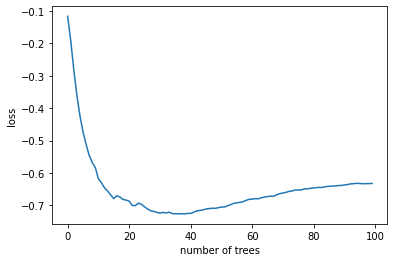

In [18]:
gbrt = GradientBoostingClassifier(n_estimators=100, 
                                  subsample=0.5,
                                  random_state=1)
gbrt.fit(X_train, y_train)
oob_loss = np.cumsum(-gbrt.oob_improvement_)

plt.plot(range(100), oob_loss)
plt.xlabel('number of trees')
plt.ylabel('loss')

plt.show()

* 그레이디언트 부스팅에 조기 종료(early stopping) 기능을 지원하기 위한 매개변수 `n_iter_no_change`, `validation_fraction`, `tol`이 추가. 
    * 훈련 데이터에서 `validation_fraction` 비율(기본값 0.1)만큼 떼어내어 측정한 손실이 `n_iter_no_change` 반복 동안에 `tol` 값(기본값 1e-4) 이상 향상되지 않으면 훈련이 멈춘다.

* 히스토그램 기반 부스팅
    * 입력 특성을 256개의 구간으로 나누어 노드를 분할에 사용
    * 일반적으로 샘플 개수가 10,000개보다 많은 경우 그레이디언트 부스팅보다 히스토그램 기반 부스팅이 훨씬 빠르다.
    * `HistGradientBoostingClassifier`



In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier
 
hgbc = HistGradientBoostingClassifier(random_state=1)
hgbc.fit(X_train, y_train)

hgbc_train_score = hgbc.score(X_train, y_train)
hgbc_test_score = hgbc.score(X_test, y_test)
print('히스토그램 기반 부스팅 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (hgbc_train_score, hgbc_test_score))

히스토그램 기반 부스팅 훈련 정확도/테스트 정확도 0.979/0.917


`HistGradientBoostingClassifier`와 `HistGradientBoostingRegressor`에서 범주형 특성을 그대로 사용할 수 있다. `categorical_featrues` 매개변수에 불리언 배열이나 정수 인덱스 배열을 전달하여 범주형 특성을 알려주어야 한다.

XGBoost(https://xgboost.ai/) 에서도 `tree_method` 매개변수를 `hist`로 지정하여 히스토그램 기반 부스팅을 사용한다.

In [20]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', eval_metric='logloss', use_label_encoder=False, random_state=1)
xgb.fit(X_train, y_train)

xgb_train_score = xgb.score(X_train, y_train)
xgb_test_score = xgb.score(X_test, y_test)

print('XGBoost 훈련 정확도/테스트 정확도 %.3f/%.3f' % (xgb_train_score, xgb_test_score))

XGBoost 훈련 정확도/테스트 정확도 0.968/0.917


또다른 히스토그램 기반 부스팅 알고리즘으로 LightGBM(https://lightgbm.readthedocs.io/) 이다.

In [21]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=1)
lgb.fit(X_train, y_train)

lgb_train_score = lgb.score(X_train, y_train)
lgb_test_score = lgb.score(X_test, y_test)

print('LightGBM 훈련 정확도/테스트 정확도 %.3f/%.3f' % (lgb_train_score, lgb_test_score))

LightGBM 훈련 정확도/테스트 정확도 0.968/0.917
